In [1]:
import glob
import numpy as np
from nanofilm.ndimage import imread
import elliPack.astroclean as at
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

In [3]:
folderpath = 'E:\example_elli-maps_forTFM\Set4-NDA__large set_normalsize_andCropped_RCE'

In [4]:
class lambdaVarEllimaps:
    
    def __init__(self, path = None, ):
        
        if path is None:
            raise ValueError('Please enter a valid path to folder containing maps from lambda variation measurement')
        else:
            self.path = path
            
        self.getmapFiles()
        self.loadAllMaps()
        self.getdatFile()
        
        
        self.n_wl = np.arange(int(self.dim3/2))
        self.Dindexes = [x for x in self.n_wl*2 if x%2 == 0]
        self.Pindexes = [x+1 for x in self.n_wl*2 if x%2 == 0]
        
        self.stackReshaped = self.all_maps.reshape(self.dim1*self.dim2, self.dim3)
        self.segmentedStack = []

    def getmapFiles(self):
        
        self.all_files = glob.glob(self.path + '/*.png')
    
    def getdatFile(self):
        
        datFile = glob.glob(self.path + '/*.ds.dat')
        if len(datFile) >= 2:
            raise ValueError('The instatiated folder contains data from more than one experiment. The folder must contain only one .ds.dat file. Please clean the files in the folder and try again')
        else:
            self.datFile = str(datFile[0])
    
    def getWavelengths(self):
        
        WLarray = np.loadtxt(self.datFile,
                             usecols=0,
                             skiprows=2)
        
        if len(WLarray) != self.n_wl:
            raise ValueError('The number of wavelength in the .dat file does not match the number of maps in the instantiated folder. The folder should have {} .png files, not more and not less'.format(self.n_wl))
        else:
            self.WLarray = WLarray
        
    
    def loadAllMaps(self):
        
        stack = list(map(at.loadmap_astroclean, self.all_files))
        self.all_maps = np.dstack(stack)
        self.dim1 = self.all_maps.shape[0]
        self.dim2 = self.all_maps.shape[1]
        self.dim3 = self.all_maps.shape[2]
        
    
    def getEstimation(self, k=(2,11), metric = 'distortion'):
        
        model = KMeans(random_state=0)
        
        visualizer = KElbowVisualizer(model, 
                                      k=k,
                                      metric = metric)
        visualizer.fit(self.stackReshaped)
        
        
        visualizer.show()
    
    #Having the two estimator visualizers in the same function makes the second estimator fail, somehow
    
    def getEstimation2(self, k=(2,11), metric = 'calinski_harabasz'):
        
        model = KMeans(random_state=0)
        
        visualizer = KElbowVisualizer(model, 
                                      k=k, 
                                      metric = metric)
        visualizer.fit(self.stackReshaped)
        
        visualizer.show()
    
    def clusterize(self, k = 5):
        
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(self.stackReshaped)
        
        segmented = kmeans.cluster_centers_[kmeans.labels_]
        
        segmentedStack = segmented.reshape(self.dim1, self.dim2, self.dim3)
        
        self.segmentedStack = segmentedStack
        
        return segmentedStack
    
    def clustershot(self):
        self.firstSegmentedmap = self.segmentedStack[:,:,0]
        #self.firstSegmentedPsimap = self.segmentedPsiStack[:,:,0] #not used at all? remove?
        #first segmented Deltamap is used to identify position of clustered pixels. 
        #It must be tested how that overlaps in psi maps, as chances are that len(pval) is then > 1
        
        all_DeltaShots = []
        all_PsiShots = []
        
        for cluster_idx in self.n_clustersList:
            
            C_ = np.unique(self.firstSegmentedmap)[cluster_idx] #select one value from unique values in first map
            C_ys, C_xs = np.where(self.firstSegmentedmap==C_) #identify position of all pixels with that value in the map
        
            C_Deltapixelshot = []

            for wl in self.indices:
                Dpxval = np.unique(self.segmentedStack[C_ys,C_xs,wl])
                C_Deltapixelshot.append(Dpxval[0]) # the [0] here is just to append the float and not the array [float]
                
        
            all_DeltaShots.append(C_Deltapixelshot)
            all_PsiShots.append(C_Psipixelshot)
        self.all_DeltaShots = all_DeltaShots
        self.all_PsiShots = all_PsiShots
        
    def pickonefromstack(self, imstack, idxSelector = 0):
        
        selected = np.dsplit(imstack, imstack.shape[2])[idxSelector]
        
        return selected
    
    def plotDeltaPsi(self, idxSelector = 0):
        
        idxDelta = self.Dindexes[idxSelector]
        idxPsi = self.Pindexes[idxSelector]
        imDelta = self.pickonefromstack(self.all_maps, idxDelta)
        imPsi = self.pickonefromstack(self.all_maps, idxPsi)
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
        fig.tight_layout()
        
        ax1.clear
        arrR1 = ax1.imshow(imDelta, cmap = 'gray')
        ax1.set_title('Delta')
        ax1.grid(b=None)
        fig.colorbar(arrR1, 
                     ax=ax1, 
                     shrink=0.5, 
                     location='left',
                     pad=0.048)
        
        ax2.clear
        arrR2 = ax2.imshow(imPsi, cmap = 'gray')
        ax2.grid(b=None)
        ax2.set_title('Psi')
        fig.colorbar(arrR2, 
                     ax=ax2, 
                     shrink=0.5, 
                     location='right')
    
    def plotSegmentedDeltaPsi(self, idxSelector = 0):
        
        idxDelta = self.Dindexes[idxSelector]
        idxPsi = self.Pindexes[idxSelector]
        imDelta = self.pickonefromstack(self.segmentedStack, idxDelta)
        imPsi = self.pickonefromstack(self.segmentedStack, idxPsi)
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
        fig.tight_layout()
        
        ax1.clear
        arrC1 = ax1.imshow(imDelta, cmap = 'viridis')
        ax1.set_title('Delta')
        ax1.grid(b=None)
        fig.colorbar(arrC1, 
                     ax=ax1, 
                     shrink=0.5, 
                     location='left',
                     pad=0.048)
        
        ax2.clear
        arrC2 = ax2.imshow(imPsi, cmap = 'viridis')
        ax2.grid(b=None)
        ax2.set_title('Psi')
        fig.colorbar(arrC2, 
                     ax=ax2, 
                     shrink=0.5, 
                     location='right')

In [5]:
xxx = lambdaVarEllimaps(folderpath)

In [6]:
xxx.clusterize()

array([[[ 20.6001  ,  19.160814,  18.809458, ..., 197.22945 ,
         197.23633 , 197.17038 ],
        [ 20.6001  ,  19.160814,  18.809458, ..., 197.22945 ,
         197.23633 , 197.17038 ],
        [ 20.6001  ,  19.160814,  18.809458, ..., 197.22945 ,
         197.23633 , 197.17038 ],
        ...,
        [ 19.15232 ,  19.169561,  18.794497, ..., 197.2342  ,
         197.23534 , 197.1691  ],
        [ 19.15232 ,  19.169561,  18.794497, ..., 197.2342  ,
         197.23534 , 197.1691  ],
        [ 19.15232 ,  19.169561,  18.794497, ..., 197.2342  ,
         197.23534 , 197.1691  ]],

       [[ 20.6001  ,  19.160814,  18.809458, ..., 197.22945 ,
         197.23633 , 197.17038 ],
        [ 20.6001  ,  19.160814,  18.809458, ..., 197.22945 ,
         197.23633 , 197.17038 ],
        [ 20.6001  ,  19.160814,  18.809458, ..., 197.22945 ,
         197.23633 , 197.17038 ],
        ...,
        [ 20.6001  ,  19.160814,  18.809458, ..., 197.22945 ,
         197.23633 , 197.17038 ],
        [ 20

In [10]:
xxx.segmentedStack.shape

(428, 262, 164)

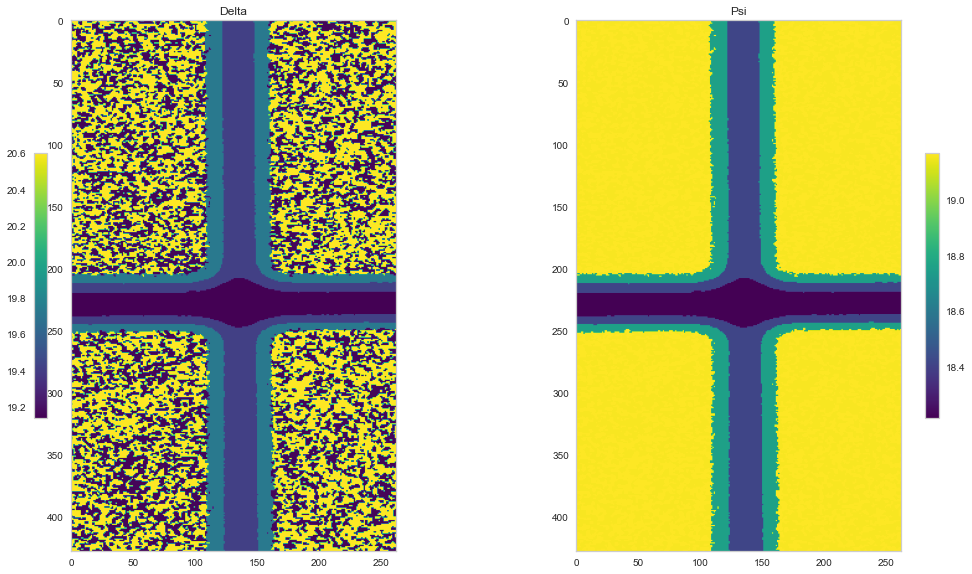

In [20]:
xxx.plotSegmentedDeltaPsi(0)

In [28]:
np.unique(xxx.segmentedStack[:,:,81])

array([12.718845, 12.723956, 13.03041 , 13.417698, 14.158697],
      dtype=float32)

hay 164 mapas. Todos los idx <=81 son psi

In [29]:
firstD = xxx.segmentedStack[:,:,82]
firstP = xxx.segmentedStack[:,:,0]
np.unique(firstD), np.unique(firstP)

(array([140.87317, 144.94113, 145.6698 , 146.35199, 147.6389 ],
       dtype=float32),
 array([19.134705, 19.15232 , 19.413055, 19.724894, 20.6001  ],
       dtype=float32))

In [44]:
#self.firstSegmentedDeltamap = self.segmentedDeltaStack[:,:,0] = firstD
#C_ = np.unique(self.firstSegmentedDeltamap)[cluster_idx] = Dc1 (o Dc2, Dc3...)
#C_ys, C_xs = np.where(self.firstSegmentedDeltamap==C_)
Cidx=1

C_ = np.unique(firstD)[Cidx]
C_ys, C_xs = np.where(firstD==C_)

#segmentedDeltaStack = np.dsplit(xxx.segmentedStack, xxx.segmentedStack.shape[2])[82:]
#segmentedPsiStack = xxx.segmentedStack[:,:,0:81]


pxshot = []
for wl in np.arange(xxx.dim3):
    
    pxval = np.unique(xxx.segmentedStack[C_ys,C_xs,wl])
    pxshot.append(pxval)


In [45]:
pxshot

[array([19.724894], dtype=float32),
 array([18.755157], dtype=float32),
 array([18.375164], dtype=float32),
 array([17.548489], dtype=float32),
 array([17.247261], dtype=float32),
 array([17.124817], dtype=float32),
 array([17.459404], dtype=float32),
 array([18.161222], dtype=float32),
 array([18.939386], dtype=float32),
 array([19.855413], dtype=float32),
 array([21.06113], dtype=float32),
 array([22.264067], dtype=float32),
 array([23.261103], dtype=float32),
 array([24.013105], dtype=float32),
 array([24.400421], dtype=float32),
 array([24.527437], dtype=float32),
 array([24.499126], dtype=float32),
 array([24.482786], dtype=float32),
 array([24.408503], dtype=float32),
 array([24.372826], dtype=float32),
 array([24.43387], dtype=float32),
 array([24.533628], dtype=float32),
 array([24.344584], dtype=float32),
 array([23.99489], dtype=float32),
 array([23.759676], dtype=float32),
 array([23.63882], dtype=float32),
 array([23.633104], dtype=float32),
 array([23.692158], dtype=float3

In [46]:
len(pxshot)

164

In [47]:
xxx.dim3

164